# Boilerplate, loading data, and the like

In [2]:
### Importing modules

%pylab
%matplotlib inline
rc('text', usetex = False)
import pandas as pd
import os
import os.path as osp
import sys
import inspect
import cPickle
from urllib import urlretrieve
from zipfile import ZipFile
sys.path.append(osp.join(os.getcwd(),'utilities','lib', 'python2.7','site-packages'))
import seaborn
seaborn.set()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
### Local modules included in this directory (chains.py stripped from CosmoSlik, which was used to
# generate chains)

cmd_subfolder = osp.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],"utilites")))
if cmd_subfolder not in sys.path:
    sys.path.insert(0, cmd_subfolder)
from utilities.chains import load_chain
from utilities.helper_functions import get_data,like1d,likelihood
#from cosmoslik_plugins.samplers.metropolis_hastings import load_chain

# An Early Universe Cosmologist Explores the Implications of Variable Stars for the Current Rate of Cosmic Expansion

### Abstract:
*Local measurements of the rate of cosmic expansion today from Cepheid variable stars (Riess et. al. 2016) are in $\sim 3 \sigma$ tension with Cosmic Microwave Background-derived inferences of the same quantity under the standard cosmological concordance model. This tension, if unexplained by systematic effects in either dataset, is evidence for new physics. In this talk, I will discuss my attempts to make sense of the variable star analysis and its assumptions, particularly in its inference of Cepheid brightness. In this talk, framed by a Jupyter Notebook available in advance by email request, I will highlight the toolbox I used for data exploration, which may be of general interest to students interested in learning how to approach academic research with an eye to a future career in industrial data science or data analysis.*
## Introduction:

### The basic problem:

Local measurements based on Cepheid Variable Stars say

### $$H_0 = \left(73.24 \pm 1.74\right) {\rm \frac{km/sec}{Mpc}}$$

High redshift measurements of the Cosmic Microwave Background say

### $$H_0 = \left(69.3 \pm 0.7 \right) {\rm \frac{km/sec}{Mpc}}$$

Who's right? I know how the CMB measurement comes about, but I want to build intuition about the Local (Riess et. al) measurement.

### Distance Ladder
Three rungs:
* So-called **geometric** measures to galaxies with parallax measurements or analogues
    * Milky Way Cepheids
    * Eclipsing binary star systems in the LMC
    * water *mega-maser* in NGC4258
    * there are more, but not included in the analysis
* Cepheid calibration of above anchor galaxies to cepheid host galaxies with type Ia Supernovae
    * 19 galaxies with Cepheids measured using Hubble Wide Field Camera 3. From R16:
    <img src="figures/r16_table1.png" width="500" />
    * ~2000 cepheids in total
* Supernovae calibration from these cepheid host galaxies is used obtain a type Ia absolute magnitude scale, to calibrate the known supernovae redshift magnitude relationship trained on $\sim 300$ supernovae at $0.023 < z < 0.15$


## First Exploration of the Data
Let's look at the data used to make the local Hubble constraint. This consists of Cepheid variable stars, and type Ia supernovae, in the galaxies in the table above, plus the Milky Way and LMC.

In [4]:
# Load the data from a scrape of a tab seperated table R16 use to do their analysis (table 4 of R16)
cepheids, sne = get_data() # a helper function in the utilities folder to load cepheids and sne into dataframes

Let's look at the characteristics we have for each of these objects:

In [5]:
cepheids.describe()

,RA,DEC,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK
count,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,15.000000,15.000000,15.000000
mean,83.896517,13.401234,19.489766,1.106239,19.613678,0.234123,8.823538,2.274400,0.185467,-0.070000
std,91.748459,33.250648,18.197687,0.286744,4.808008,0.160328,0.182403,0.907511,0.092617,0.056061
min,0.000000,-69.575260,2.504000,0.350000,1.302000,0.081000,8.420000,0.348000,0.038000,-0.180000
25%,0.000000,0.000000,4.923750,0.900000,14.460000,0.095000,8.650000,2.095000,0.130000,-0.110000
50%,11.654860,0.000000,13.265000,1.040000,20.245000,0.147000,8.822000,2.300000,0.160000,-0.050000
75%,184.698515,41.910843,28.490000,1.250000,24.082500,0.337250,8.912250,2.690000,0.255000,-0.025000
max,334.581700,59.346330,99.200000,2.490000,26.800000,0.733000,9.334000,3.710000,0.330000,-0.010000


In [6]:
sne.describe()

,m^B_0,err
count,19.000000,19.000000
mean,12.387816,0.118632
std,0.841766,0.006970
min,9.746500,0.109000
25%,12.216000,0.115000
50%,12.419000,0.116000
75%,12.937500,0.120500
max,13.470000,0.142000


## Description of Features
Cepheids:
* Field: the host galaxy for the cepheid
* RA/DEC: Right ascension/declination (location in the sky). Mostly just tells us what galaxy we're in, so degenerate with above
* ID: unique Cepheid ID (for what catalogue I'm not sure--I'd like to know)
* Period: The period of Cepheid variation
* $V-I$: The color of a cepheid, defined by the difference in magnitude between V (visible) and I (infrared) measurements
* $m_H$: the magnitude (log brightness) in the Hubble WFC3 H band (chosen to reduce systematics due to dust)
* $\sigma_{\rm tot}$: the total error on the H band magnitude from all sources as determined by R16
    * crowding error $\sigma_{\rm sky}$: incorrectly assigning photons from other objects to the Cepheid (or overcorrection of said)
    * color error $\sigma_{\rm ct}$: variations in the magnitude estimate in V versus I due to Cepheid blending
    * phase error $\sigma_{\rm ph}$: where in the period the cepheid is when measured can change its magnitude.
    * intrinsic dispersion $\sigma_{\rm int}$: not actually error, but stochastic contribution to cepheid magnitude.
  Total error is given by $$\sigma_{\rm tot}^2 = \sigma_{\rm sky}^2 + \sigma_{\rm ct}^2 + \sigma_{\rm int}^2 +\left( \sigma_{\rm ph} f_{\rm ph}\right)^2,$$ where $f_{\rm ph}$ is the fraction of a period unobserved.
* Z: metallicity as defined by $log_{10}[O/H]$
* Parallax: Geometric parallax measure (for Milky Way Cepheids only)
* p_err: error on parallax. Leads to an error in magnitude (distance modulus) space by $\sigma_{\rm mag} = \frac{5}{\ln 10} \frac{\sigma_p}{parallax}$
* LK: So called Lutz-Kelker corrections to distance modulii from parallax measurements. The equation is
$$\mu_{\pi} = 5 \log_{10} \left(\frac{10^{-3}}{Parallax}\right) + 25 - LK$$
  
  
  
Supernovae:
* Host: the host galaxy for the supernovae
* sne: the supernovae name
* $m^B_0$: the measured B band magnitude at peak brightness
* err: the error on this measurement.

## Feature Engineering. 
Let's implement the equations in the above into the dataframes:


In [7]:
cepheids['mu_pi'] = 5 * log10(10**-3/cepheids.parallax) + 25 - cepheids.LK
cepheids['TotalError'] = sqrt(cepheids.sigma_tot**2 
                              + cepheids.p_err.fillna(0)**2)
cepheids['Period'] = log10(cepheids['Period'])
## And get rid of columns we don't want
cepheids_processed = cepheids.drop(['RA', 'DEC', 'ID', 
                                    'parallax', 'p_err', 'LK', 
                                    'sigma_tot'], axis = 1);


## View on Category (Field/Host)
To get a better idea of the data, let's split the sample into individual galaxies. First, a count of Cepheids in each galaxy:

In [8]:
cepheid_count = cepheids_processed.groupby('Field')['Field'].count()
cepheid_count ## Pick a specific value using cepheid_count.<field>

Field
galaxy     15
lmc       775
m101      251
m31       372
n1015      14
n1309      44
n1365      32
n1448      54
n2442     141
n3021      18
n3370      63
n3447      80
n3972      42
n3982      16
n4038      13
n4258     139
n4424       3
n4536      33
n4639      25
n5584      83
n5917      13
n7250      22
u9391      28
Name: Field, dtype: int64

We see that 30% of the Cepheids in the sample are in the LMC, 30% more are in m101 and m31, another 15% in NGC4258 and NGC2442, and the other 25% spread between the other 20 galaxies in the sample. It's pretty assymetric. 

Here's some summary statistics on the samples by field:

In [9]:
cepheids_processed.groupby('Field').mean()

,Period,VminusI,m_H,Z,mu_pi,TotalError
Field,,,,,,
galaxy,0.826805,1.016000,3.720667,8.900000,8.606736,0.290237
lmc,0.704068,0.935548,13.895794,8.650000,NaN,0.092094
m101,1.190467,1.091673,22.921514,9.142665,NaN,0.302084
m31,0.968408,1.250054,19.071102,8.900000,NaN,0.147000
n1015,1.750737,1.307143,24.610000,8.772214,NaN,0.320929
n1309,1.728978,1.211818,24.625227,8.860273,NaN,0.353545
n1365,1.495285,1.075000,24.197187,8.762750,NaN,0.324219
n1448,1.445080,1.013148,24.276481,8.796500,NaN,0.301963
n2442,1.479506,1.574326,24.590922,8.935986,NaN,0.519184


The most obvious assymetry here is in the mean period over galaxies. The Milky Way, LMC, m101, m31, and N4258 have very small periods compared to the others. This has a noticeable effect on the magnitude, the pearson r between Period and magnitude is 0.55. There's also a weaker but significant dependence on color (r ~ 0.38), while metallicity seems uncorrelated.

In [10]:
cepheids_processed.corr()

,Period,VminusI,m_H,Z,mu_pi,TotalError
Period,1.000000,0.469921,0.678574,3.706650e-01,3.082245e-01,0.522219
VminusI,0.469921,1.000000,0.326481,2.763142e-01,7.383706e-01,0.313481
m_H,0.678574,0.326481,1.000000,5.489921e-01,8.402786e-01,0.751112
Z,0.370665,0.276314,0.548992,1.000000e+00,2.062575e-16,0.531256
mu_pi,0.308224,0.738371,0.840279,2.062575e-16,1.000000e+00,0.132926
TotalError,0.522219,0.313481,0.751112,5.312557e-01,1.329262e-01,1.000000


In [11]:
cepheids_processed.groupby(pd.cut(cepheids_processed.Period, 
                                  3,
                                  labels = ['low', 'medium','high'],
                                 )
                          ).median()

,Period,VminusI,m_H,Z,mu_pi,TotalError
Period,,,,,,
low,0.621436,0.90,14.490,8.6500,8.246650,0.0960
medium,1.232361,1.11,22.885,8.9000,9.857014,0.2605
high,1.609968,1.21,24.120,8.8595,8.512520,0.2835


## A Model
physics says the magnitude of anything should obey the following relationship:
$$m = M + \mu,$$
where $m$ is the observed apparent magnitude, $M$ is intrinsic absolute magnitude, and $\mu$, known as the distance modulus, is related to the (luminosity) distance by $$\mu = 5 \log_{10} \frac{D}{\rm Mpc} - 25.$$

We know that Cepheids (and supernovae) in the same galaxy should have the same $\mu$. Labeling each field with $i$ and each Cepheid with $(i,\alpha)$, we have

$$m_{\alpha,i} = M_{\alpha} + \mu_i$$

$M_{\alpha}$ depends only on the Cepheid properties and represents the absolute (inherent) magntitude of a Cepheid independent of distance. Let's model it as

$$M_{\alpha} = M_{\rm ceph} + \mathcal{f}\left(\log_{10}P, (V-I), \log_10 [O/H]\right) + \eta.$$

The term $M_{\rm ceph}$ is important to the notion of a standardizeable ruler. If we invert the above equation, and can both find $M_{\alpha}$ for a Cepheid and determine the form of $f$, we have an underlying Cepheid characteristic $M_{\rm ceph}$ we claim to be common to all Cepheids. That lets us determine $M_{\rm ceph}$ for Cepheids where we can determine $M_{\alpha}$, and then use that value of $M_{\rm ceph}$ to infer $M_{\alpha}$, and therefore and estimate of $\mu_i$, for Cepheids where $M_{\rm ceph}$ is not determinable (because we don't know the distance $\mu_i$ to turn measured $m_{\alpha, i}$ into $M_{\alpha}$. 

We have a couple choices for modeling $f$. The simplest is linear, where we take

$$\mathcal{f}\left(\log_{10} P, (V-I), \log_{10} [O/H]\right) = b (\log_{10} P - 1) + R (V-I) + \gamma (\log_{10} [O/H] - 8.9).$$

In this case, our total model can be seen as a model on the apparent magnitudes $m_{\alpha, i}$:
$$m_{\alpha,i} - \mu_i = M_{\rm ceph} + b (\log_{10} P - 1) + R (V-I) + \gamma (\log_{10} [O/H] - 8.9).$$

We can train this model to determine the coefficients $(b, R, \gamma)$ on the data where the $\mu_i$ is known, and use it to predict the $\mu_i$ outside this region.


In [12]:
geometric_distances = pd.DataFrame({'lmc' : (18.494, 0.0452),
                                    'n4258' : (29.387, 0.02616*2.17),
                                    'galaxy' : (0,0)
                                    }, 
                                    index = ['mu', 'sigma_mu']
                                   ).T
cephs_and_dist = cepheids_processed.join(geometric_distances, on = 'Field')
cephs_and_dist['TotalError'] = sqrt(cephs_and_dist.TotalError**2 
                                    + cephs_and_dist.sigma_mu.fillna(0)**2)
cephs_and_dist['mu'] = (cephs_and_dist.mu.fillna(0) 
                              + cephs_and_dist.mu_pi.fillna(0)).replace(0, np.nan)
cephs_and_dist.drop(['mu_pi', 'sigma_mu'], axis = 1, inplace = True)

In [13]:
cephs_and_dist.groupby('Field').median()

,Period,VminusI,m_H,Z,TotalError,mu
Field,,,,,,
galaxy,0.761025,0.970,3.778,8.9000,0.272976,8.251361
lmc,0.612678,0.910,14.190,8.6500,0.100713,18.494000
m101,1.184975,1.050,22.930,9.1450,0.293000,NaN
m31,0.946157,1.195,19.090,8.9000,0.147000,NaN
n1015,1.792286,1.285,24.550,8.7350,0.315000,NaN
n1309,1.708414,1.200,24.590,8.8610,0.330000,NaN
n1365,1.482373,1.030,24.225,8.8050,0.317000,NaN
n1448,1.419701,1.025,24.335,8.8020,0.281000,NaN
n2442,1.469085,1.620,24.600,8.9510,0.527000,NaN


In [14]:
from sklearn.linear_model import LinearRegression ### This is chi2 regression

linear_regression = LinearRegression()

# including \mu_pi for parallax information
known_distance = cephs_and_dist['mu'].notnull()
features = cephs_and_dist.loc[known_distance, ['Period','VminusI', 'Z']]
features['Period'] -= 1
features['Z'] -= 8.9
#get_dummies breaks a categorical feature into dummy features that are either 1 or 0,
#which lets a linear model fit a parameter to each category in the categorical
#(in our case the \mu_i to each galaxy)
        
target = cephs_and_dist.loc[known_distance, 'm_H'] - cephs_and_dist.loc[known_distance, 
                                                                        'mu']
error = cephs_and_dist.loc[known_distance, 'TotalError']

linear_regression.fit(features, target, sample_weight = 1/error);


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


We can look at the coefficients of this regression:

In [15]:
regression_coefficients = pd.DataFrame((zip(features.columns, linear_regression.coef_) 
                                       + [('M_ceph', linear_regression.intercept_)]),
                                       columns = ['Feature', 'Coefficient']
                                       )
regression_coefficients

,Feature,Coefficient
0,Period,-3.291531
1,VminusI,0.522884
2,Z,-0.262920
3,M_ceph,-6.127719


The feature $M_{\rm ceph}$ is the standardized candle for Cepheids, and represents the expected absolute magnitude of a Cepheid of period 10 days, $V-I = 0$, and $\log_{10} [0/H] = 8.9$.  

We can fit for the training set to look at the residual:


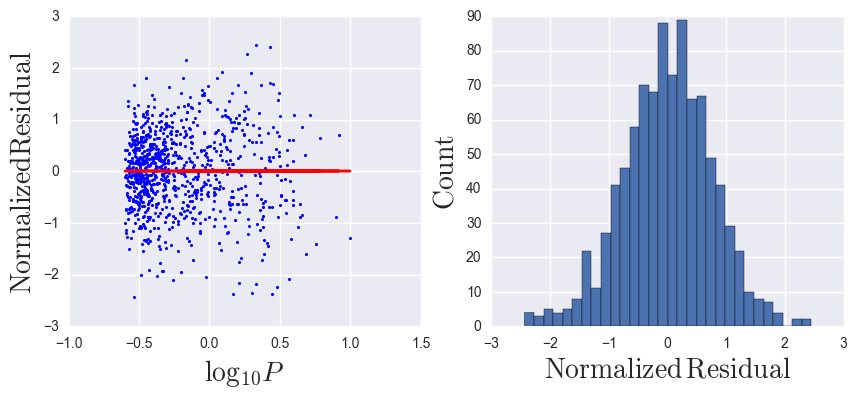

In [16]:
figure(figsize (10,4))
subplot(121)
scatter(features.Period, (target - linear_regression.predict(features))/error, s = 5, lw = 0)
plot(features.Period, zeros(target.size), c = 'r')
xlabel(r'$\log_{10} P$', fontsize = 20)
ylabel(r'${\rm Normalized Residual}$', fontsize = 20)
subplot(122)
hist((target - linear_regression.predict(features))/error, bins = 30);
xlabel(r'${\rm Normalized\, Residual}$', fontsize = 20)
ylabel(r'${\rm Count}$', fontsize = 20)



Now we can make predictions for the records where $m_{\alpha, i} - \mu_i$ is unknown:

In [17]:
features = cephs_and_dist.loc[:, ['Period','VminusI', 'Z']]
features['Period'] -= 1
features['Z'] -= 8.9
target = cephs_and_dist.loc[:, 'm_H'] - cephs_and_dist.loc[:, 
                                                           'mu']
error = cephs_and_dist.loc[:, 'TotalError']

predictions = linear_regression.predict(features);

In [18]:
cephs_and_dist['LR_mu'] = cephs_and_dist['m_H'] - predictions
cephs_and_dist.groupby('Field').median()

,Period,VminusI,m_H,Z,TotalError,mu,LR_mu
Field,,,,,,,
galaxy,0.761025,0.970,3.778,8.9000,0.272976,8.251361,8.362429
lmc,0.612678,0.910,14.190,8.6500,0.100713,18.494000,18.497522
m101,1.184975,1.050,22.930,9.1450,0.293000,NaN,29.185742
m31,0.946157,1.195,19.090,8.9000,0.147000,NaN,24.439712
n1015,1.792286,1.285,24.550,8.7350,0.315000,NaN,32.506791
n1309,1.708414,1.200,24.590,8.8610,0.330000,NaN,32.575504
n1365,1.482373,1.030,24.225,8.8050,0.317000,NaN,31.385652
n1448,1.419701,1.025,24.335,8.8020,0.281000,NaN,31.328301
n2442,1.469085,1.620,24.600,8.9510,0.527000,NaN,31.473817


We can try to fit for some nonlinear features using a Random Forest approach. Note this does not require the Cepheids to be 'standardizeable' in the same sense; there won't be a $M_{\rm ceph}$. It does require that the Cepheids we want to predict aren't too far off from the distribution of trained Cepheids, which may or may not be true.

In [19]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators= 5000, n_jobs = -1)
features = cephs_and_dist.loc[known_distance, ['Period', 'VminusI', 'Z']]
target = (cephs_and_dist.loc[known_distance, 'm_H'] 
          - cephs_and_dist.loc[known_distance, 'mu']
          )
error = cephs_and_dist.loc[known_distance, 'TotalError']

In [20]:
random_forest.fit(features, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=5000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [21]:
features = cephs_and_dist.loc[:, ['Period','VminusI', 'Z']]
#features['Period'] -= 1
#features['Z'] -= 8.9
target = cephs_and_dist.loc[:, 'm_H'] - cephs_and_dist.loc[:, 
                                                           'mu']
error = cephs_and_dist.loc[:, 'TotalError']

predictions = random_forest.predict(features);

cephs_and_dist['RF_mu'] = cephs_and_dist['m_H'] - predictions
cephs_and_dist.groupby('Field').median()

,Period,VminusI,m_H,Z,TotalError,mu,LR_mu,RF_mu
Field,,,,,,,,
galaxy,0.761025,0.970,3.778,8.9000,0.272976,8.251361,8.362429,8.278183
lmc,0.612678,0.910,14.190,8.6500,0.100713,18.494000,18.497522,18.496016
m101,1.184975,1.050,22.930,9.1450,0.293000,NaN,29.185742,29.130603
m31,0.946157,1.195,19.090,8.9000,0.147000,NaN,24.439712,24.454789
n1015,1.792286,1.285,24.550,8.7350,0.315000,NaN,32.506791,32.427684
n1309,1.708414,1.200,24.590,8.8610,0.330000,NaN,32.575504,32.536144
n1365,1.482373,1.030,24.225,8.8050,0.317000,NaN,31.385652,31.398641
n1448,1.419701,1.025,24.335,8.8020,0.281000,NaN,31.328301,31.287161
n2442,1.469085,1.620,24.600,8.9510,0.527000,NaN,31.473817,31.614187


That's pretty cool; the predictions are pretty similar. Not insensible!

If we want to do actual inference with any of this we need errors on our predictions. I'll ignore the Linear Regression case (after all, this is just $\chi^2$ repackaged). To get errorbars on the random forest, we'll use an implementation of *Infinitesimal Jackknife* errors from Wager et. al <ref>https://arxiv.org/abs/1311.4555<ref>.

This is a bootstrapping technique that estimates the variance $V$ on the prediction $\hat{y}$ of a bag of predictors (e.g. the random forest) on a record $x$ as the sum of squares of the covariance between the number of times each training record $x'$ appears in the training sample of a tree with the prediction $f(x)$ of that tree:
$$V(x) = \sum_i \langle N_i, f(x) \rangle ^2$$

In [22]:
import forestci as fci 
# errorbars for random forests from https://arxiv.org/abs/1311.4555 (Wager et. al.)
# This is cheating a bit because the 
in_bag = fci.calc_inbag(features.loc[known_distance, :].shape[0], random_forest)
rf_IJK_variance = fci.random_forest_error(random_forest, 
                        in_bag, 
                        features.loc[known_distance, :],
                        features.loc[:, :]
                        )

In [23]:
IJK_error = np.sqrt(abs(rf_IJK_variance))
error = pd.DataFrame(cephs_and_dist.groupby('Field').std()['RF_mu'])
#error['LK_error'] = IJK_error
error.columns = ['sample_error']
cephs_and_dist_withErr = cephs_and_dist.join(error, on = 'Field')
cephs_and_dist_withErr['IJK_error'] = IJK_error
cephs_and_dist_withErr.groupby('Field').median()

,Period,VminusI,m_H,Z,TotalError,mu,LR_mu,RF_mu,sample_error,IJK_error
Field,,,,,,,,,,
galaxy,0.761025,0.970,3.778,8.9000,0.272976,8.251361,8.362429,8.278183,1.506797,0.175572
lmc,0.612678,0.910,14.190,8.6500,0.100713,18.494000,18.497522,18.496016,0.033631,0.199597
m101,1.184975,1.050,22.930,9.1450,0.293000,NaN,29.185742,29.130603,0.341224,0.148790
m31,0.946157,1.195,19.090,8.9000,0.147000,NaN,24.439712,24.454789,0.198630,0.159818
n1015,1.792286,1.285,24.550,8.7350,0.315000,NaN,32.506791,32.427684,0.395911,0.315404
n1309,1.708414,1.200,24.590,8.8610,0.330000,NaN,32.575504,32.536144,0.324688,0.269266
n1365,1.482373,1.030,24.225,8.8050,0.317000,NaN,31.385652,31.398641,0.363958,0.193765
n1448,1.419701,1.025,24.335,8.8020,0.281000,NaN,31.328301,31.287161,0.358362,0.189745
n2442,1.469085,1.620,24.600,8.9510,0.527000,NaN,31.473817,31.614187,0.409493,0.187031


## Determining $H_0$

The final determination of $H_0$ comes from combining the above Cepheid work with the standardized candles of type Ia supernovae in the Hubble flow (and also the 19 that exist inside the galaxies with Cepheid-estimated distances. The particulars of their standardization are out of the scope of this exposition, but the inferred B-band magnitudes are stored in the *sne* DataFrame.

These inferred values of $m_B^0$, combined with our predictions of $\mu_i$ above, can be fed into the distance modulus equation
$$m_{B,i}^0 = \mu_i + M_0^{\rm SN}$$
for an inference of $M_0^{\rm SN}$. This value, an inferred estimate for the peak absolute $B$-band magnitude of type Ia supernovae, can be used to anchor the empirical type Ia supernovae magnitude-redshift relationship for supernovae in the Hubble flow. For each supernovae in the Hubble flow,
\begin{equation}
M_b^0 = m_b^0 - 5 \log \left( D_{\rm lum}/{\rm Mpc}\right) - 25 ,
\end{equation}
which, when combined with the equation for luminosity distance at cosmic distances,
$$D_{\rm lum} = \frac{c}{H_0} \int_0^z \frac{dz'}{h(z')}$$
gives
\begin{equation}
M_b^0 = 5 \log{H_0} +m_b^0 - 5 \log \left(cz f(z)\right) - 25,
\end{equation}
where the $a_B = f(z) - m_B^0/5$ represents the intercept of the type Ia magnitude-redshift relation. This is fit to order 300 observed $(m_B^0, z)$ pairs to third order,
\begin{align}
a_B &= \frac{1}{z}\int_0^z \frac{dz'}{h(z')} - \frac{m_B^0}{5}  \\
& \simeq 1 + \frac{1}{2} h'(0) z + \frac{1}{6} h''(0)z^2 - \frac{m^0_B}{5},\nonumber
\end{align}
to give $a_B = 0.7162 \pm 0.0018$. In turn, a local determination of $H_0$ is then given by 
## $$H_0 = 10^{0.2 M_b^0 + a_B + 5}.$$

The thing we need in the above equation is $M_b^0$.


In [24]:
from scipy.optimize import curve_fit
def sne_app_mag(x, Mag):
    return x['RF_mu'] + Mag


data = cephs_and_dist_withErr.merge(sne, left_on = 'Field', right_on = 'Host')


data['SN_TotErr'] = sqrt(data.err**2 + data.sample_error**2)
fit_vals = data.groupby('Field').mean()

M_sne, pcov = curve_fit(sne_app_mag, fit_vals, fit_vals['m^B_0'], sigma = fit_vals['SN_TotErr'])
H_0 = 10**(0.2 * M_sne + 0.7162 + 5)
eH_0 = sqrt(((0.2 * log(10) * H_0) * sqrt(pcov[0]))**2 + (log(10) * H_0 * 0.0018)**2)

print 'sample variance error bars: ', H_0[0], eH_0[0]




data['SN_TotErr'] = sqrt(data.err**2 + data.IJK_error**2)
fit_vals = data.groupby('Field').mean()


M_sne, pcov = curve_fit(sne_app_mag, fit_vals, fit_vals['m^B_0'], sigma = fit_vals['SN_TotErr'])
H_0 = 10**(0.2 * M_sne + 0.7162 + 5)
eH_0 = sqrt(((0.2 * log(10) * H_0) * sqrt(pcov[0]))**2 + (log(10) * H_0 * 0.0018)**2)
print 'jackknife errorbars: ', H_0[0], eH_0[0]




sample variance error bars:  72.879384036 1.16209879817
jackknife errorbars:  72.2911261116 1.23892781415


With the jackknfir errors, the Random Forest method gives a value of 
$$H_0 = \left(72.498 \pm 1.265 \right) {\rm \frac{km/s}{Mpc}},$$
while when using sample variance error bars we get 
$$H_0 = \left(72.498 \pm 1.164 \right) {\rm \frac{km/s}{Mpc}}.$$
Both are similar to the constraint from the linear regression model, which we'll skip for brevity (jackknife is straightforward in the linear case). The errors are smaller: some of that is due to R16 blowing up their errors to account for a $1\%$ systematic effect, which not being included in the above analysis; some of that is due to the Random Forest finding a value of $H_0$ which is about a percent smaller than the R16 value, and some is presumably due to either the RF errors or the R16 errors being under/over estimated, respectively.

The main takeaway here is that nonlinear effects in the Cepheid inference are probably unimportant.

## Validation.
Let's look at the Type Ia supernovae residuals. The $\chi^2$ is 1 per degree of freedom in the jackknife error case (which, since the bootstrapping in the jackknife refers to the samples used to train each tree in the foreset, wasn't guaranteed). This isn't that suprising, because a plot of the cepheid distribution (also below) shows there isn't a lot of extrapolation going on.

Additional things we could do:
* Cross validation. Split Cepheids into dedicated test and training sets, so that the errors can be estimated with fully independent tests. Mostly useful if the model suffers from high variance in predictions between populations, which is a sign of model overcomplexity. Since we get similar predictions to the linear regression case (which is about as simple as you can go), this is probably unneccessary.
* look at variations on predictions of $H_0$ from a random subset of the forest (chosen with replacement). This is another way to boostrap errorbars, and will give a handle on systematic uncertainty. This is a benefit over other methods, where systematic errors have to be guessed by e.g. data jackknifing.


chi2 is 7.23056567335


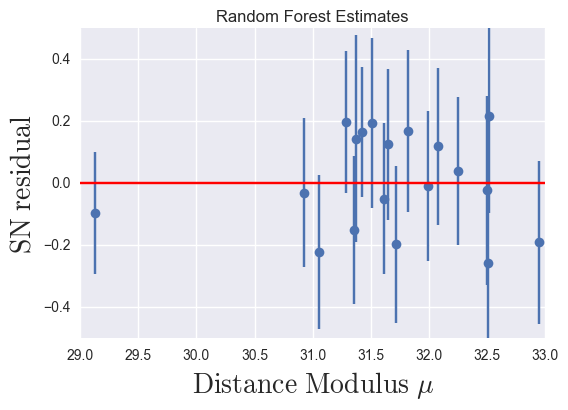

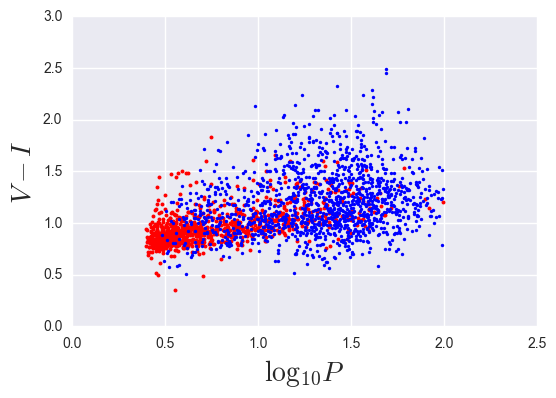

In [25]:
figure( figsize = (6,4))
errorbar(fit_vals['RF_mu'], fit_vals['m^B_0']-sne_app_mag(fit_vals, M_sne), yerr = fit_vals['SN_TotErr'], fmt = 'o')
x = arange(29,34)
y = zeros(x.size)
plot(x,y, c = 'r');
xlabel(r'${\rm Distance\  Modulus\  } \mu$', fontsize = 20)
ylabel(r'${\rm SN\  residual} $', fontsize = 20)
title(r'Random Forest Estimates')
ylim(-0.5, 0.5)
print 'chi2 is', sum((fit_vals['m^B_0']-sne_app_mag(fit_vals, M_sne))**2/fit_vals['SN_TotErr']**2)

figure( figsize = (6,4))
cephs = cepheids
cephs['is_training'] = 0
is_training = cephs['Field'].isin(['galaxy', 'lmc', 'n4258'])
cephs.loc[is_training, 'is_training'] = 1
scatter(cephs.loc[is_training, 'Period'], cephs.loc[is_training, 'VminusI'], 
        c = 'r', label = 'training', s = 8, lw = 0)
scatter(cephs.loc[~is_training, 'Period'], cephs.loc[~is_training, 'VminusI'], 
        c = 'b', label = 'training', s = 6, lw = 0)
xlabel(r'$\log_{10}P$', fontsize = 20)
ylabel(r'$V-I$', fontsize = 20)

## Expanding the Regression Method
### (and getting Error bars)
Riess et. al use a version of the linear regression method above, with the following changes:
* The coefficient in front of the color is fixed to R = 0.39 using external datasets (n.b. the regime of this validity is questionable)
* The regression algorithm is expanded to semi-supervised learning, where the structure of points inside the galaxies is allowed to contribute to determining the linear coefficients. 
* They allow for a break in the period relationship at $P = 10$ days whose existence is evidenced from both this and external data sets. The evidence is marginal.
* Error bars are estimated through Fisher estimation (Hessian analysis), rather than boostrapping.

None of the above really changes the results, except the aformentioned increase in the errors.

### On top of this,
there are a few more things we can do incorporate more physics.
* The correction for color include the total measured $(V-I)$. The correction is due to reddening effects along the line of sight, so we should correct this term by subtracting out intrinsic Cepheid color $(V-I)^0$, due to the fact that Cepheids have a different brightness in different frames.
* We can try to look for more general breaks in the linear behavior beyond the break at $P = 10$ days. We'll do this with a Gaussian Mixture Model.
* The above introduces nonlinear effects, which means we'll switch to a more robust method of measuring error bars through MCMC sampling of the underlying model parameter distributions.





In [26]:
### Download the chains if they're not in the directory already
for filename in ['r16_treatment_thinned.chain', 
             'base_thinned.chain', 
             'base_manypops_thinned.chain',
             'varyR_thinned.chain',
             'varyR_manypops_thinned.chain'
            ]:
    if filename not in os.listdir(osp.join(os.getcwd(), 'data', 'chains')):
        print 'file %s not found. Downloading chains'%filename                          
        handle, _ = urlretrieve('https://www.dropbox.com/s/kq8y6zsrtkt3fer/required_chains.zip?dl=1', 
                                osp.join(os.getcwd(), 'data', 'chains','chains.zip')
                               )
        ZipFile(handle).extractall(path = osp.join(os.getcwd(), 'data', 'chains'))
    else:
        pass

In [27]:
r16 = pd.DataFrame(load_chain('data/chains/r16_treatment_thinned.chain'))
base = pd.DataFrame(load_chain('data/chains/base_thinned.chain'))
manypops = pd.DataFrame(load_chain('data/chains/base_manypops_thinned.chain'))
varyR = pd.DataFrame(load_chain('data/chains/varyR_thinned.chain'))
varyR_manypops = pd.DataFrame(load_chain('data/chains/varyR_manypops_thinned.chain'))


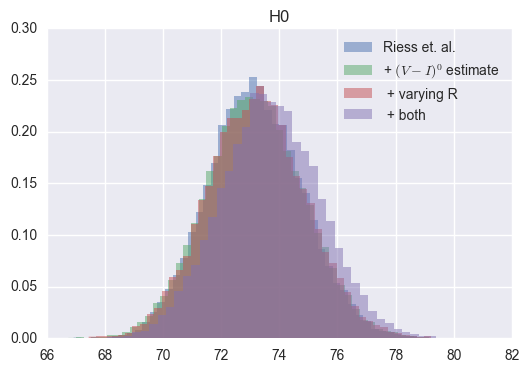

In [28]:
fig = figure(figsize = (6,4))
ax = gca()
r16.hist('H0', bins = 50, normed = True, label = r'Riess et. al.', ax=  ax, alpha = 0.5, lw = 0)
base.hist('H0', bins = 50, normed = True, label = r'+ $(V-I)^0$ estimate', ax = ax,alpha = 0.5, lw = 0)
manypops.hist('H0', bins = 50, normed = True, label = r' + varying R', ax = ax,alpha = 0.5, lw = 0)
varyR_manypops.hist('H0', bins = 50, normed = True, label = r' + both', ax = ax,alpha = 0.5, lw = 0)


legend(frameon = False)

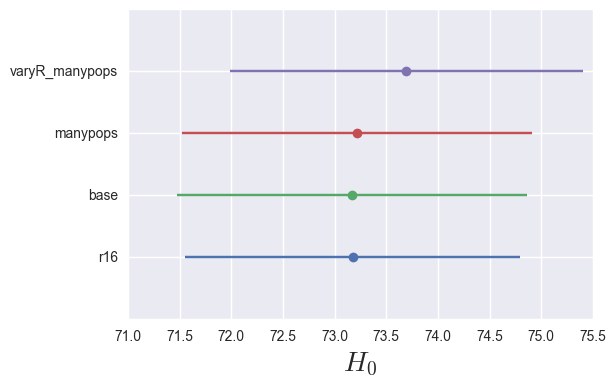

In [29]:
fig = figure(figsize = (6,4))
chainnames = ['r16', 'base', 'manypops', 'varyR_manypops']
for i,chainname in enumerate(chainnames):
    chain = eval(chainname)
    errorbar(chain.H0.mean(), i, xerr= chain.H0.std(), label = chainname, fmt = 'o')
ylim(-1, i+1)
#legend(frameon = False)
xlabel(r'$H_0$', fontsize = 20)
gca().set_yticklabels([''] + chainnames)


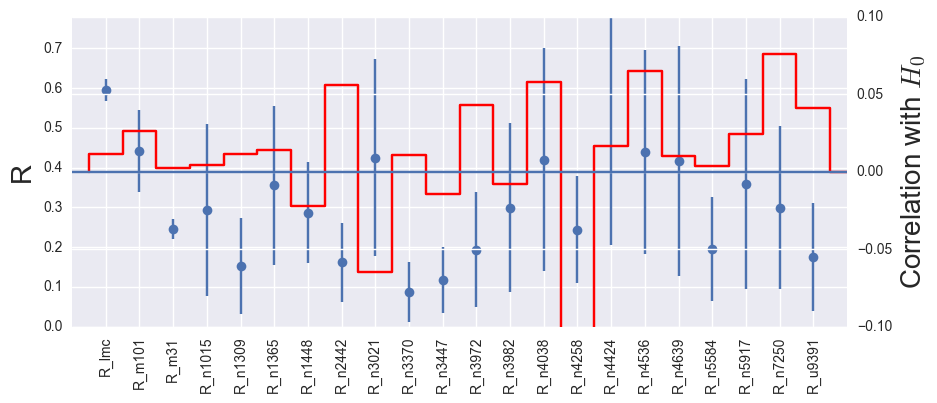

In [30]:
r_vals = [col for col in varyR.columns if col.startswith('R_')]
correlations = varyR.corr().loc[r_vals , 'H0']
vals = varyR[r_vals].mean() + 0.39
err = varyR[r_vals].std()

ax1 = subplot(111)
errorbar(arange(len(r_vals)), vals, yerr= err, fmt = 'o')
xlim(-1, 22)
ylim(0.39 - 0.39, 0.39 + 0.39)
xticks(arange(0,22),correlations.index, rotation = 'vertical')
ylabel('R', fontsize = 20)

ax2 = twinx(ax1)
plot(arange(-1, 23)+0.5, [0] + correlations.tolist() + [0], ls = 'steps', c = 'r')
plot(arange(-1, 24), zeros(25))
ylim(-.1, .1)
xlim(-1, 22);
ylabel('Correlation with $H_0$', fontsize =20)


In [31]:
from sklearn.mixture import GaussianMixture
features = cepheids[['Period', 'VminusI']]
bic_array = []
for n_classes in arange(1,15):
    model = GaussianMixture(n_components = n_classes, max_iter = 100, n_init = 40, init_params= 'random')
    estimate = model.fit(features)
    bic_array += [model.bic(features)]

(0, 16)

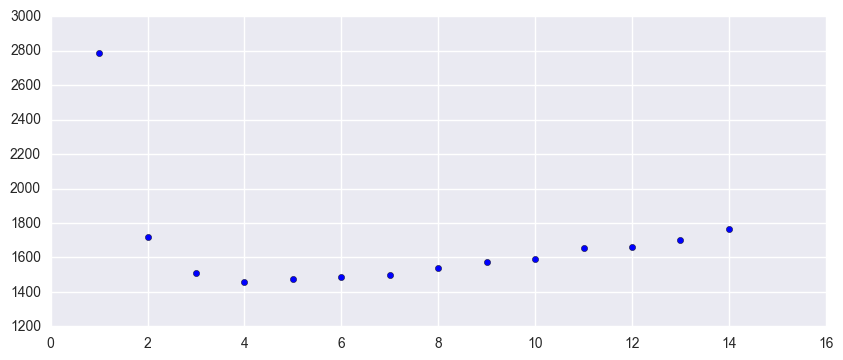

In [32]:
scatter(arange(1,15), bic_array)
xlim(0,16)

In [33]:
n_classes = 6
gmm = GaussianMixture(n_components = n_classes, max_iter = 100, n_init = 100, init_params= 'random')
gmm.fit(features);

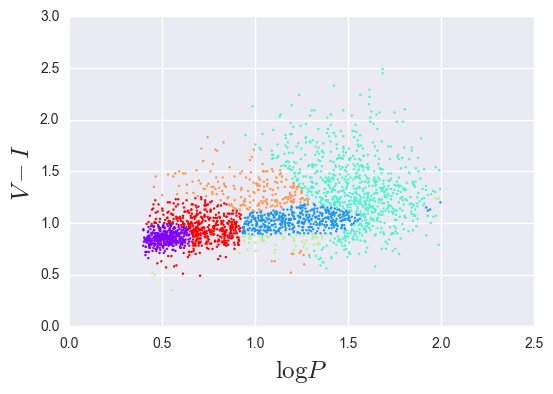

In [34]:
figure(figsize = (6,4))
cmap = get_cmap('rainbow', 6)
cephs['population'] = gmm.predict(features)
scatter(cephs.Period, cephs.VminusI, s= 3, lw = 0, cmap = cmap, c = cephs.population)
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);

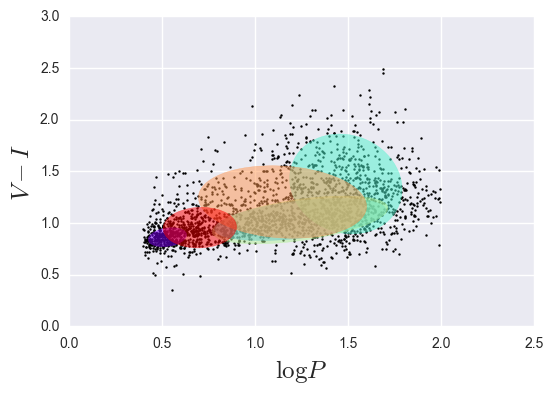

In [35]:
from numpy.linalg import norm
figure(figsize = (6,4))
ax = gca()
scatter(cephs.Period, cephs.VminusI, s= 3, 
        lw = 0, color = 'k'
       )

for pop in arange(6):
    v, w = eigh(gmm.covariances_[pop][:2,:2])
    u = w[0]/norm(w[0])
    angle = arctan2(u[1], u[0]) * 180/pi
    v = 2 * sqrt(2) * sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[pop, :2], 
                              v[0], v[1], 180 + angle,
                              color = cmap(pop))
    ell.set_alpha(0.5)
    ax.add_artist(ell)

xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);

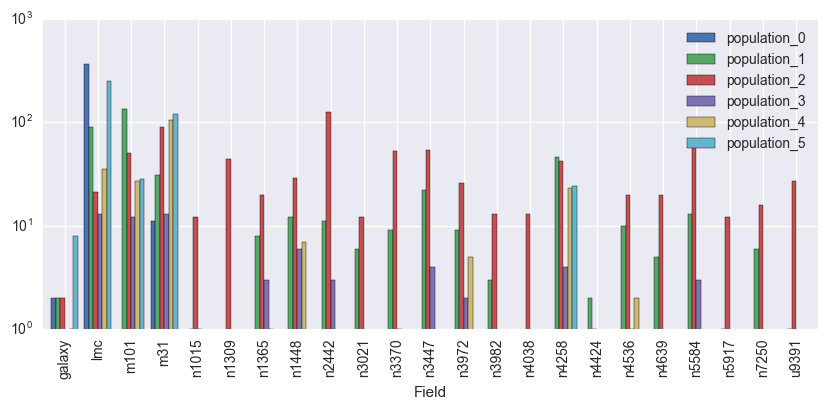

In [36]:
field = 'n4258'
counts = pd.get_dummies(cephs[['Field', 'population']], columns = ['population']).groupby('Field').sum()
#figure(figsize = (10, 4))
#ax = gca()
counts.plot.bar(width = 0.8)
gca().set_yscale('log')
#cephs.groupby(['Field', 'population']).count().loc[[(field,i) for i in arange(6)], :]
#ylim(0,100);
#counts.plot.bar?

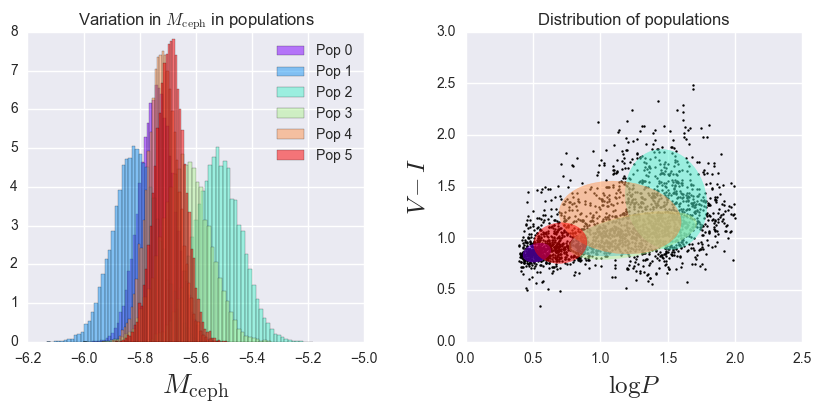

In [37]:
cols = [col for col in manypops.columns if col.startswith('M_ceph')]
figure(figsize = (10,4))
ax = subplot(121)
for i, col in enumerate(cols):
    if col == 'M_ceph0':
        manypops.hist(col, bins = 50, alpha = 0.5, color = cmap(i/6.0), ax = ax, normed = True, label = 'Pop '+col[-1])
    else:
        manypops['temp'] = chain[col] + chain['M_ceph0']
        manypops.hist('temp',bins = 50, alpha = 0.5, color = cmap(i/6.0), ax = ax, normed = True, label = 'Pop '+col[-1])
        manypops.drop(['temp'], axis = 1)
xlabel(r'$M_{\rm ceph}$', fontsize = 20)
legend(frameon = False)
ax.set_title(r'Variation in $M_{\rm ceph}$ in populations')

ax = subplot(122)
scatter(cephs.Period, cephs.VminusI, s= 3, 
        lw = 0, color = 'k'
       )

for pop in arange(6):
    v, w = eigh(gmm.covariances_[pop][:2,:2])
    u = w[0]/norm(w[0])
    angle = arctan2(u[1], u[0]) * 180/pi
    v = 2 * sqrt(2) * sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[pop, :2], 
                              v[0], v[1], 180 + angle,
                              color = cmap(pop))
    ell.set_alpha(0.5)
    ax.add_artist(ell)
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);
title('Distribution of populations')